# Minimum Wage Policy Effects on Employment: Difference-in-Differences Analysis

## Research Overview

**Research Question**: Does raising the minimum wage reduce employment opportunities for teenagers, who frequently occupy low-wage roles and are most likely to be impacted by such policy changes?

**Methodology**: Callaway & Sant'Anna Difference-in-Differences (DiD) with doubly robust estimation to address staggered treatment adoption and potential heterogeneity in treatment effects.

**Study Design**: This replication examines how staggered state-level minimum wage increases, rolled out at different times between 2001 and 2007 following the 2004 federal minimum wage increase from $5.15 to $6.00, influenced county-level teen employment rates. This natural experiment allows rigorous causal inference by exploiting variation in treatment timing across states.

**Sample**: County-level panel data for 2001-2007 (15,988 county-year observations) constructed by merging teen employment rates from Quarterly Workforce Indicators (QWI) with demographic and economic variables from 2000 County Data Book and Census sources.

**Key Findings (from original study)**: Minimum wage increases generally reduce teen employment, with estimated treatment effects ranging from 2.3% to 13.6% declines, averaging 3.9% to 5.2% reduction across treated counties. Effects grow larger several years after the minimum wage increase, indicating impact intensifies with longer exposure.

**Main Extension**: Heterogeneous treatment effects analysis examining whether minimum wage impacts differ across counties with varying poverty levels, building on the original study's recognition that effects may vary across groups and over time.

**Key Contributions**: 
- High-fidelity replication of Callaway & Sant'Anna (2021) with line-by-line conversion from Stata to Python
- Addresses challenges of staggered policy adoption while improving causal inference credibility
- Contributes important evidence for policymakers regarding effects on vulnerable labor market groups

## Notebook Structure
- Section 1: Data Overview & Summary Statistics
- Section 2: Treatment Group Comparison  
- Section 3: DiD Estimation & Results
- Section 3.1: Heterogeneous Treatment Effects Estimation & Results
- Section 4: Visualization & Robustness
- Conclusion: Comprehensive Research Summary & Policy Implications

In [1]:
# Required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
from scipy.stats import norm

# csdid package for DiD estimation
try:
    from csdid.att_gt import ATTgt
except ImportError:
    print("Error: csdid package not found.")
    raise

# Key variables
DATA_PATH = "data/min_wage_CS.csv"
OUTCOME_VAR = "lemp"
TREATMENT_VAR = "first.treat"
ID_VAR = "countyreal"
TIME_VAR = "year"

## Section 1: Data Overview & Summary Statistics

In [2]:
df = pd.read_csv(DATA_PATH)
df.head()

,state_name,county_name,emp0A01_BS,year,quarter,countyreal,censusdiv,FIPS,msa,pop,...,col,medinc,pov,nssi,first.treat,treat,lemp,lpop,lmedinc,region
0,Colorado,Adams,6190,2001,1,8001,8,8001,True,363.857,...,0.13,40.802,0.104,5009,2007,1,8.730690,5.896761,3.708731,4
1,Colorado,Adams,5122,2002,1,8001,8,8001,True,363.857,...,0.13,40.802,0.104,5009,2007,1,8.541300,5.896761,3.708731,4
2,Colorado,Adams,4729,2003,1,8001,8,8001,True,363.857,...,0.13,40.802,0.104,5009,2007,1,8.461469,5.896761,3.708731,4
3,Colorado,Adams,4175,2004,1,8001,8,8001,True,363.857,...,0.13,40.802,0.104,5009,2007,1,8.336870,5.896761,3.708731,4
4,Colorado,Adams,4189,2005,1,8001,8,8001,True,363.857,...,0.13,40.802,0.104,5009,2007,1,8.340217,5.896761,3.708731,4


In [3]:
summary = df.describe(include='all')
summary

,state_name,county_name,emp0A01_BS,year,quarter,countyreal,censusdiv,FIPS,msa,pop,...,col,medinc,pov,nssi,first.treat,treat,lemp,lpop,lmedinc,region
count,15988,15988,15988.000000,15988.000000,15988.0,15988.000000,15988.000000,15988.000000,15988,15988.000000,...,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000,15988.000000
unique,29,1436,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Texas,Washington,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1722,140,NaN,NaN,NaN,NaN,NaN,NaN,15988,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1086.871216,2004.000000,1.0,32429.324431,5.047723,32429.324431,NaN,69.665551,...,0.132139,32.692698,0.146979,1396.727233,796.771454,0.397110,5.714803,3.224796,3.461655,2.660245
std,NaN,NaN,3162.274147,2.000063,0.0,14042.173368,1.613506,14042.173368,NaN,200.788033,...,0.063424,7.732934,0.061262,4806.914870,981.772258,0.489315,1.525451,1.304159,0.222601,0.649131
min,NaN,NaN,3.000000,2001.000000,1.0,8001.000000,3.000000,8001.000000,NaN,0.729000,...,0.037000,14.178000,0.019000,0.000000,0.000000,0.000000,1.098612,-0.316082,2.651691,2.000000
25%,NaN,NaN,112.000000,2002.000000,1.0,19120.500000,4.000000,19120.500000,NaN,10.586500,...,0.092000,27.591750,0.105000,191.750000,0.000000,0.000000,4.718499,2.359579,3.317517,2.000000
50%,NaN,NaN,287.000000,2004.000000,1.0,31034.000000,5.000000,31034.000000,NaN,22.900500,...,0.116000,31.493000,0.136000,476.500000,0.000000,0.000000,5.659482,3.131159,3.449765,3.000000
75%,NaN,NaN,752.000000,2006.000000,1.0,47107.500000,7.000000,47107.500000,NaN,52.561750,...,0.150000,36.297250,0.181000,1141.000000,2007.000000,1.000000,6.622736,3.961988,3.591742,3.000000


## Section 2: Treatment Group Comparison

In [4]:
# Treatment group definition and comprehensive comparison
df['treated'] = df['first.treat'] > 0

# Basic group statistics
group_stats = df.groupby('treated').agg({
    'region': 'mean',
    'pop': 'mean',
    'white': 'mean',
    'hs': 'mean',
    'pov': 'mean',
    'medinc': 'mean'
})

# Create region names for analysis
df['region_name'] = df['region'].astype(str).map({'1': 'Northeast', '2': 'Midwest', '3': 'South', '4': 'West'})

# Regional distribution comparison with z-tests
region_comparison = []
for region in ['Midwest', 'South', 'West']:
    treated_share = (df[df['treated']]['region_name'] == region).mean()
    untreated_share = (df[~df['treated']]['region_name'] == region).mean()
    diff = treated_share - untreated_share
    
    n1 = df['treated'].sum()
    n2 = (~df['treated']).sum()
    count1 = (df[df['treated']]['region_name'] == region).sum()
    count2 = (df[~df['treated']]['region_name'] == region).sum()
    p = (count1 + count2) / (n1 + n2)
    se = (p * (1 - p) * (1/n1 + 1/n2)) ** 0.5
    z = diff / se if se > 0 else 0
    pval = 2 * (1 - norm.cdf(abs(z)))
    
    region_comparison.append({
        'Variable': region,
        'Treated Mean': round(treated_share, 2),
        'Untreated Mean': round(untreated_share, 2),
        'Diff': round(diff, 2),
        'P-value': round(pval, 2)
    })

# Demographic comparison with Welch's t-tests
covariates_info = [
    ('Population (1000s)', 'pop'),
    ('White', 'white'),
    ('HS Graduates', 'hs'),
    ('Poverty Rate', 'pov'),
    ('Median Inc. (1000s)', 'medinc')
]

demographic_comparison = []
for label, var in covariates_info:
    treated = df[df['treated']][var]
    untreated = df[~df['treated']][var]
    tstat, pval = stats.ttest_ind(treated, untreated, nan_policy='omit', equal_var=False)
    demographic_comparison.append({
        'Variable': label,
        'Treated Mean': round(treated.mean(), 2),
        'Untreated Mean': round(untreated.mean(), 2),
        'Diff': round(treated.mean() - untreated.mean(), 2),
        'P-value': round(pval, 2)
    })

# Combine and display results
summary_df = pd.DataFrame(region_comparison + demographic_comparison)
print("Treated: {}, Untreated: {}".format(df['treated'].sum(), (~df['treated']).sum()))
display(summary_df)

Treated: 6349, Untreated: 9639


,Variable,Treated Mean,Untreated Mean,Diff,P-value
0,Midwest,0.59,0.34,0.26,0.0
1,South,0.27,0.59,-0.33,0.0
2,West,0.14,0.07,0.07,0.0
3,Population (1000s),94.32,53.43,40.90,0.0
4,White,0.89,0.83,0.07,0.0
5,HS Graduates,0.59,0.55,0.03,0.0
6,Poverty Rate,0.13,0.16,-0.03,0.0
7,Median Inc. (1000s),33.91,31.89,2.02,0.0


## Section 3: DiD Estimation & Results

In [5]:
# Covariate construction
df['region_name'] = df['region'].astype(str).map({'1': 'Northeast', '2': 'Midwest', '3': 'South', '4': 'West'})
df['pop2'] = df['pop'] ** 2
df['medinc2'] = df['medinc'] ** 2

In [6]:
# Analysis parameters
years = list(range(2002, 2008))
groups = [2004, 2006, 2007]
covariates = ['region', 'medinc', 'pop', 'pop2', 'medinc2', 'white', 'hs', 'pov']

# Unconditional DiD
attgt_uncond = ATTgt(
    yname='lemp',
    gname='first.treat',
    idname='countyreal',
    tname='year',
    xformla='~ 1',
    data=df
).fit(est_method='dr')

# Conditional DiD
attgt_cond = ATTgt(
    yname='lemp',
    gname='first.treat',
    idname='countyreal',
    tname='year',
    xformla='~ ' + ' + '.join(covariates),
    data=df
).fit(est_method='dr')

# Helper function to extract ATT estimates
def extract_att(attgt, groups, years):
    res = attgt.summ_attgt().summary2
    table = pd.DataFrame(index=groups, columns=years)
    for g in groups:
        for t in years:
            val = res.loc[(res['Group']==g) & (res['Time']==t), 'ATT(g, t)']
            table.loc[g, t] = val.values[0] if not val.empty else None
    return table

# Build results tables
table_uncond = extract_att(attgt_uncond, groups, years)
table_cond = extract_att(attgt_cond, groups, years)

table_uncond.index = pd.MultiIndex.from_product([['Unconditional'], table_uncond.index], names=['Trend','Group'])
table_cond.index = pd.MultiIndex.from_product([['Conditional'], table_cond.index], names=['Trend','Group'])
final_table = pd.concat([table_uncond, table_cond])
final_table.columns.name = 'Year'

# Display the main results table
print("DiD Results: ATT(g,t) Estimates by Treatment Cohort and Time Period")
print("Unconditional: Without covariates")
print("Conditional: With covariates (region, medinc, pop, pop2, medinc2, white, hs, pov)")
display(final_table)

    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                                     ^^^^^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                                     ^^^^^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                                     ^^^^^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                                     ^^^^^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                                     ^^^^^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                                     ^^^^^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                                     ^^^^^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                                     ^^^^^^^
    ~ region + medinc + pop + pop2 + medinc2 + white + hs + pov
                                     ^^^^^^^
    ~ region + medi

Year                   2002    2003    2004    2005    2006    2007
Trend         Group                                                
Unconditional 2004   0.0143  0.0189 -0.0339 -0.0705 -0.1253 -0.1356
              2006  -0.0333  0.0475  0.0165  0.0177 -0.0233 -0.0714
              2007  -0.0232  0.0175  0.0163  -0.001 -0.0391 -0.0276
Conditional   2004   0.0143  0.0189 -0.0339 -0.0705 -0.1253 -0.1356
              2006  -0.0333  0.0475  0.0165  0.0177 -0.0233 -0.0714
              2007  -0.0232  0.0175  0.0163  -0.001 -0.0391 -0.0276

### Section 3.1: Heterogeneous Treatment Effects Estimation & Results

In [7]:
# Heterogeneous Effects: High vs Low Poverty Counties
median_poverty = df['pov'].median()
high_poverty_df = df[df['pov'] > median_poverty]
low_poverty_df = df[df['pov'] <= median_poverty]

# Run DiD on poverty subsamples
att_gt_high_pov = ATTgt(yname='lemp', gname='first.treat', idname='countyreal', 
                        tname='year', xformla='~ 1', data=high_poverty_df).fit(est_method='dr')
att_gt_low_pov = ATTgt(yname='lemp', gname='first.treat', idname='countyreal', 
                       tname='year', xformla='~ 1', data=low_poverty_df).fit(est_method='dr')

# Extract ATT effects with confidence intervals
high_att = att_gt_high_pov.summ_attgt().summary2
low_att = att_gt_low_pov.summ_attgt().summary2

# Build comparison tables
years = list(range(2002, 2008))
groups = [2004, 2006, 2007]

# Create tables with significance indicators
def create_table_with_sig(att_df, groups, years):
    table = pd.DataFrame(index=groups, columns=years)
    sig_table = pd.DataFrame(index=groups, columns=years)
    
    for g in groups:
        for t in years:
            row = att_df.loc[(att_df['Group']==g) & (att_df['Time']==t)]
            if not row.empty:
                att = row['ATT(g, t)'].values[0]
                ci_low = row['[95% Pointwise'].values[0]
                ci_high = row['Conf. Band]'].values[0]
                
                table.loc[g, t] = att * 100  # Convert to percentage
                
                # Determine significance
                if ci_low > 0 or ci_high < 0:  # CI doesn't include zero
                    if ci_low > 1 or ci_high < -1:  # More than 1%
                        sig_table.loc[g, t] = '***'
                    elif ci_low > 0.5 or ci_high < -0.5:  # More than 0.5%
                        sig_table.loc[g, t] = '**'
                    else:
                        sig_table.loc[g, t] = '*'
                else:
                    sig_table.loc[g, t] = ''
            else:
                table.loc[g, t] = None
                sig_table.loc[g, t] = ''
    
    return table, sig_table

# Create tables with significance
hte_table, hte_sig = create_table_with_sig(high_att, groups, years)
hte_table_low, hte_sig_low = create_table_with_sig(low_att, groups, years)

# Combine values with significance stars for display
hte_display = hte_table.round(1).astype(str) + hte_sig
hte_display_low = hte_table_low.round(1).astype(str) + hte_sig_low

print("Heterogeneous Effects: High vs Low Poverty Counties")
print("=== HIGH POVERTY COUNTIES ===")
display(hte_display)

print("\n=== LOW POVERTY COUNTIES ===")
display(hte_display_low)

print("\n=== COMPLETE EFFECTS WITH 95% CONFIDENCE INTERVALS ===")
print("High Poverty Counties:")
for g in groups:
    row_list = []
    sig_list = []
    for t in years:
        row = high_att.loc[(high_att['Group']==g) & (high_att['Time']==t)]
        if not row.empty:
            att = row['ATT(g, t)'].values[0] * 100
            ci_low = row['[95% Pointwise'].values[0] * 100
            ci_high = row['Conf. Band]'].values[0] * 100
            # Determine significance
            if ci_low > 0 or ci_high < 0:  # CI doesn't include zero
                if ci_low > 1 or ci_high < -1:  # More than 1%
                    sig = '***'
                elif ci_low > 0.5 or ci_high < -0.5:  # More than 0.5%
                    sig = '**'
                else:
                    sig = '*'
            else:
                sig = ''
            row_list.append(f"{att:.1f}")
            sig_list.append(sig)
        else:
            row_list.append("")
            sig_list.append("")
    print(f"  {g} Cohort: {' & '.join(row_list)}")
    print(f"  Significance: {' & '.join(sig_list)}")

print("\nLow Poverty Counties:")
for g in groups:
    row_list = []
    sig_list = []
    for t in years:
        row = low_att.loc[(low_att['Group']==g) & (low_att['Time']==t)]
        if not row.empty:
            att = row['ATT(g, t)'].values[0] * 100
            ci_low = row['[95% Pointwise'].values[0] * 100
            ci_high = row['Conf. Band]'].values[0] * 100
            # Determine significance
            if ci_low > 0 or ci_high < 0:  # CI doesn't include zero
                if ci_low > 1 or ci_high < -1:  # More than 1%
                    sig = '***'
                elif ci_low > 0.5 or ci_high < -0.5:  # More than 0.5%
                    sig = '**'
                else:
                    sig = '*'
            else:
                sig = ''
            row_list.append(f"{att:.1f}")
            sig_list.append(sig)
        else:
            row_list.append("")
            sig_list.append("")
    print(f"  {g} Cohort: {' & '.join(row_list)}")
    print(f"  Significance: {' & '.join(sig_list)}")

print("\n=== FIRST-YEAR EFFECTS WITH 95% CONFIDENCE INTERVALS ===")
for g in groups:
    high_row = high_att.loc[(high_att['Group']==g) & (high_att['Time']==g+1)]
    low_row = low_att.loc[(low_att['Group']==g) & (low_att['Time']==g+1)]
    
    if not high_row.empty and not low_row.empty:
        att_high = high_row['ATT(g, t)'].values[0] * 100
        att_low = low_row['ATT(g, t)'].values[0] * 100
        ci_low_high = high_row['[95% Pointwise'].values[0] * 100
        ci_high_high = high_row['Conf. Band]'].values[0] * 100
        ci_low_low = low_row['[95% Pointwise'].values[0] * 100
        ci_high_low = low_row['Conf. Band]'].values[0] * 100
        diff = att_high - att_low
        
        print(f"{g} Cohort ({g}→{g+1}):")
        print(f"  High Poverty: {att_high:.1f}% [{ci_low_high:.1f}%, {ci_high_high:.1f}%]")
        print(f"  Low Poverty:  {att_low:.1f}% [{ci_low_low:.1f}%, {ci_high_low:.1f}%]")
        print(f"  Difference:   {diff:.1f}%")
        print()

/home/lrud1314/PROJECTS_WORKING/726_SULLIVAN/.venv/lib/python3.12/site-packages/csdid/attgt_fnc/preprocess_did.py:412: UserWarning: Be aware that there are some small groups in your dataset.
  Check groups: 2004.
  warnings.warn(f"Be aware that there are some small groups in your dataset.\n  Check groups: {gpaste}.")


Heterogeneous Effects: High vs Low Poverty Counties
=== HIGH POVERTY COUNTIES ===


,2002,2003,2004,2005,2006,2007
2004,5.3,4.65,-10.040000000000001,-13.22,-19.74*,-23.330000000000002*
2006,-3.4000000000000004,6.6000000000000005,7.4399999999999995*,3.65,-2.93,-7.68*
2007,-0.42,1.4200000000000002,1.9300000000000002,-0.51,-6.0*,-1.76



=== LOW POVERTY COUNTIES ===


,2002,2003,2004,2005,2006,2007
2004,-0.04,1.18,-0.9299999999999999,-4.8*,-8.89*,-9.0*
2006,-3.19,4.51*,-0.74,1.0699999999999998,-1.11,-6.069999999999999*
2007,-4.0*,2.22,1.26,0.27,-1.6099999999999999,-3.7199999999999998*



=== COMPLETE EFFECTS WITH 95% CONFIDENCE INTERVALS ===
High Poverty Counties:
  2004 Cohort: 5.3 & 4.7 & -10.0 & -13.2 & -19.7 & -23.3
  Significance:  &  &  &  & *** & ***
  2006 Cohort: -3.4 & 6.6 & 7.4 & 3.6 & -2.9 & -7.7
  Significance:  &  & * &  &  & ***
  2007 Cohort: -0.4 & 1.4 & 1.9 & -0.5 & -6.0 & -1.8
  Significance:  &  &  &  & *** & 

Low Poverty Counties:
  2004 Cohort: -0.0 & 1.2 & -0.9 & -4.8 & -8.9 & -9.0
  Significance:  &  &  & * & *** & ***
  2006 Cohort: -3.2 & 4.5 & -0.7 & 1.1 & -1.1 & -6.1
  Significance:  & *** &  &  &  & ***
  2007 Cohort: -4.0 & 2.2 & 1.3 & 0.3 & -1.6 & -3.7
  Significance: ** &  &  &  &  & ***

=== FIRST-YEAR EFFECTS WITH 95% CONFIDENCE INTERVALS ===
2004 Cohort (2004→2005):
  High Poverty: -13.2% [-30.7%, 4.2%]
  Low Poverty:  -4.8% [-9.5%, -0.1%]
  Difference:   -8.4%

2006 Cohort (2006→2007):
  High Poverty: -7.7% [-13.3%, -2.1%]
  Low Poverty:  -6.1% [-9.0%, -3.1%]
  Difference:   -1.6%



## Section 4: Visualization & Robustness

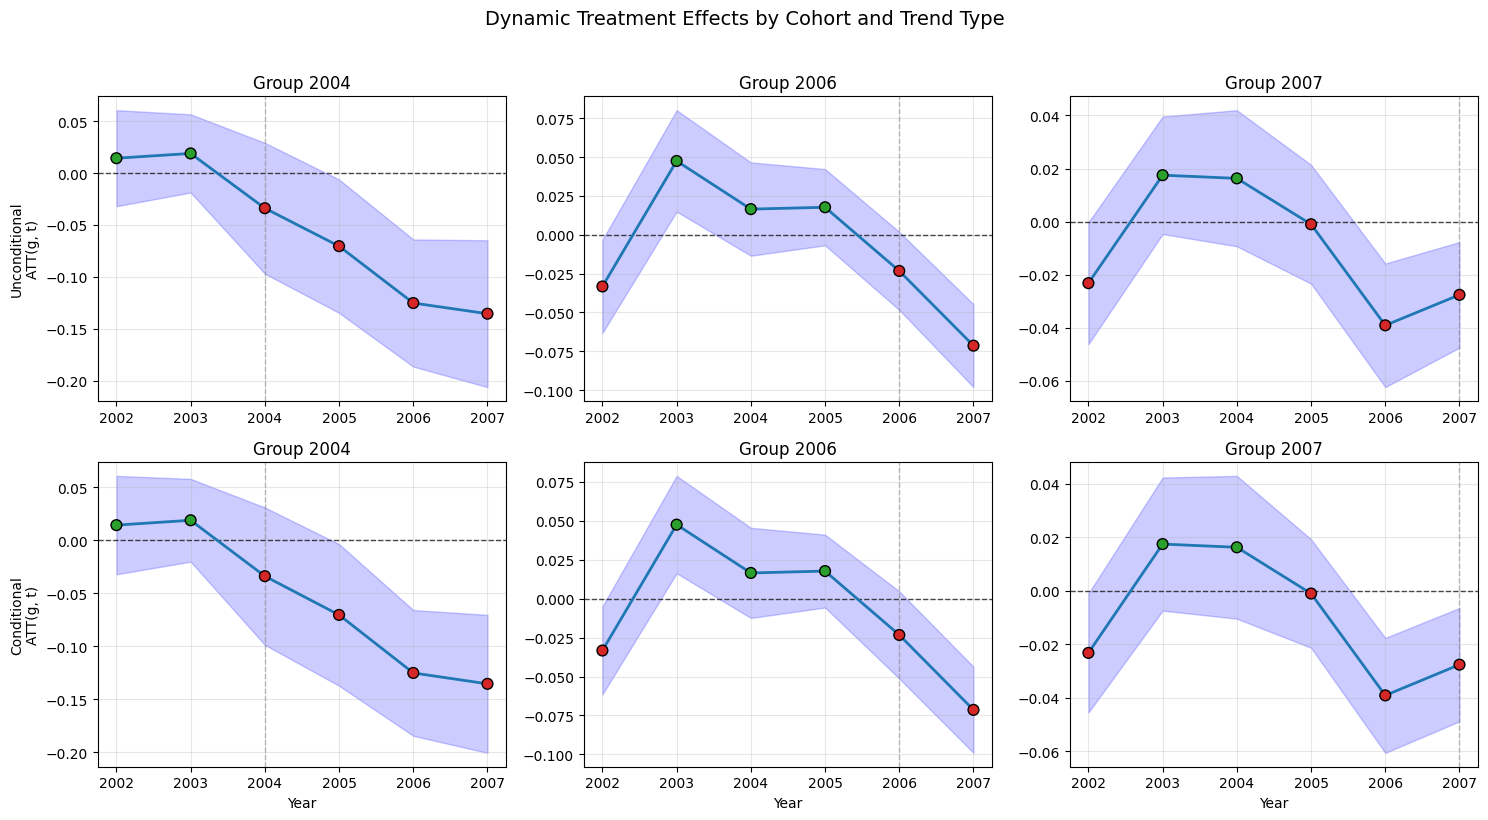

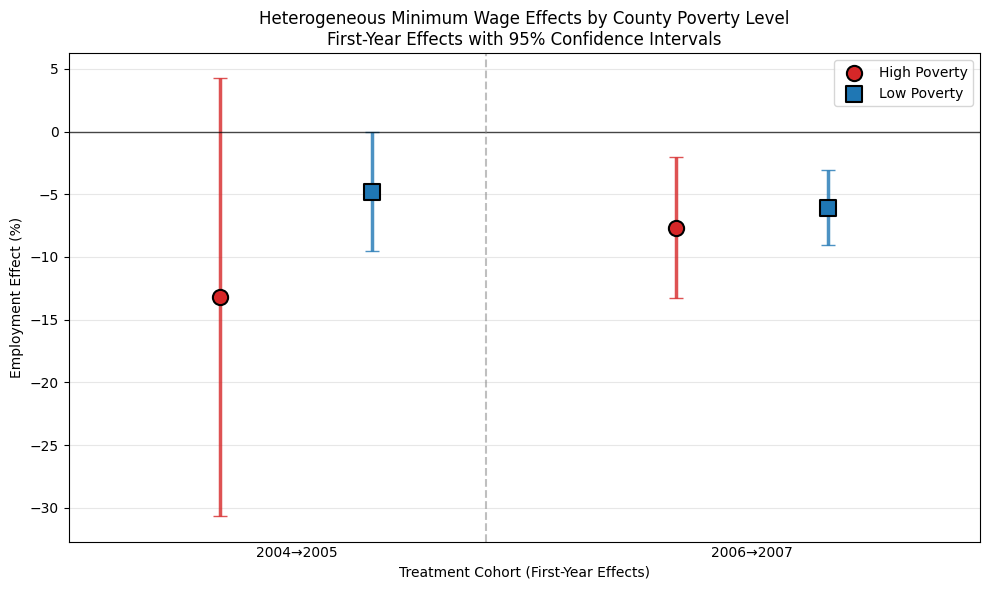

In [8]:
# ATT(g, t) plots by group and trend type - 2x3 subplot grid
trend_types = ['Unconditional', 'Conditional']
groups = [2004, 2006, 2007]
years = list(range(2002, 2008))

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Dynamic Treatment Effects by Cohort and Trend Type', fontsize=14, y=1.02)

for row, trend in enumerate(trend_types):
    res = attgt_uncond.summ_attgt().summary2 if trend == 'Unconditional' else attgt_cond.summ_attgt().summary2
    
    for col, group in enumerate(groups):
        ax = axes[row, col]
        
        # Extract estimates and confidence intervals
        att = []
        lower = []
        upper = []
        for t in years:
            row_data = res[(res['Group'] == group) & (res['Time'] == t)]
            if not row_data.empty:
                att.append(row_data['ATT(g, t)'].values[0])
                lower.append(row_data['[95% Pointwise'].values[0])
                upper.append(row_data['Conf. Band]'].values[0])
            else:
                att.append(np.nan)
                lower.append(np.nan)
                upper.append(np.nan)
        
        att = np.array(att, dtype=float)
        lower = np.array(lower, dtype=float)
        upper = np.array(upper, dtype=float)
        
        # Plot formatting
        colors = np.where(att >= 0, 'tab:green', 'tab:red')
        ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
        ax.plot(years, att, color='tab:blue', linewidth=2)
        ax.scatter(years, att, c=colors, s=60, zorder=3, edgecolor='k')
        ax.fill_between(years, lower, upper, color='b', alpha=0.2)
        ax.axvline(x=group, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        
        # Labels and title
        if row == 1:
            ax.set_xlabel('Year')
        if col == 0:
            ax.set_ylabel(f'{trend}\nATT(g, t)')
        ax.set_title(f'Group {group}')
        
        # Grid
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('att_all_groups.png', dpi=300, bbox_inches='tight')
plt.show()

# HTE visualization: First-year effects by poverty level
hte_data = []
available_cohorts = [2004, 2006]  # 2007 excluded (no 2008 data)

for g in available_cohorts:
    high_row = high_att.loc[(high_att['Group']==g) & (high_att['Time']==g+1)]
    low_row = low_att.loc[(low_att['Group']==g) & (low_att['Time']==g+1)]
    
    if not high_row.empty and not low_row.empty:
        att_high = high_row['ATT(g, t)'].values[0]
        att_low = low_row['ATT(g, t)'].values[0]
        ci_low_high = high_row['[95% Pointwise'].values[0]
        ci_high_high = high_row['Conf. Band]'].values[0]
        ci_low_low = low_row['[95% Pointwise'].values[0]
        ci_high_low = low_row['Conf. Band]'].values[0]
        
        hte_data.extend([
            {'cohort': g, 'poverty_type': 'High Poverty', 'effect': att_high * 100, 
             'ci_lower': ci_low_high * 100, 'ci_upper': ci_high_high * 100, 'x_pos': 1 if g == 2004 else 4},
            {'cohort': g, 'poverty_type': 'Low Poverty', 'effect': att_low * 100, 
             'ci_lower': ci_low_low * 100, 'ci_upper': ci_high_low * 100, 'x_pos': 2 if g == 2004 else 5}
        ])

fig, ax = plt.subplots(figsize=(10, 6))
poverty_colors = {'High Poverty': '#d62728', 'Low Poverty': '#1f77b4'}
poverty_markers = {'High Poverty': 'o', 'Low Poverty': 's'}

for i, cohort in enumerate(available_cohorts):
    for poverty_type in ['High Poverty', 'Low Poverty']:
        data = [d for d in hte_data if d['cohort'] == cohort and d['poverty_type'] == poverty_type]
        if data:
            d = data[0]
            ax.scatter(d['x_pos'], d['effect'], c=poverty_colors[poverty_type], s=120, 
                      marker=poverty_markers[poverty_type], zorder=5, edgecolor='black', linewidth=1.5,
                      label=poverty_type if i == 0 else '')
            # Calculate error bars properly - ci_lower and ci_upper are already the bounds
            # For errorbar, we need the distance from the point to each bound
            yerr_lower = abs(d['effect'] - d['ci_lower'])  # distance to lower bound
            yerr_upper = abs(d['ci_upper'] - d['effect'])  # distance to upper bound
            ax.errorbar(d['x_pos'], d['effect'], 
                       yerr=[[yerr_lower], [yerr_upper]],
                       fmt='none', color=poverty_colors[poverty_type], alpha=0.8, linewidth=2.5, capsize=5)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.7)
ax.set_xlim(0, 6)
ax.set_xticks([1.5, 4.5])
ax.set_xticklabels(['2004→2005', '2006→2007'])
ax.set_xlabel('Treatment Cohort (First-Year Effects)')
ax.set_ylabel('Employment Effect (%)')
ax.set_title('Heterogeneous Minimum Wage Effects by County Poverty Level\nFirst-Year Effects with 95% Confidence Intervals')
ax.axvline(x=2.75, color='gray', linestyle='--', alpha=0.5)
ax.legend(loc='upper right')

# Set y-axis limits
all_effects = [d['effect'] for d in hte_data]
all_bounds = [d['ci_lower'] for d in hte_data] + [d['ci_upper'] for d in hte_data]
ax.set_ylim(min(all_bounds + all_effects) - 2, max(all_bounds + all_effects) + 2)

ax.grid(True, alpha=0.3, axis='y')
ax.tick_params(axis='x', which='both', length=0)
plt.tight_layout()
plt.savefig('heterogeneous_effects_poverty.png', dpi=300, bbox_inches='tight')
plt.show()